In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [84]:
data_train = pd.read_csv("train.csv").fillna(0)
y_train = np.array(pd.read_csv("train.csv")["Transported"].fillna(0).astype(float))
data_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [85]:
def enc(x):
    x = np.array(x).reshape(-1,1).astype(str)
    return pd.DataFrame(OrdinalEncoder().fit_transform(x) + 1).fillna(0)


def transform(data):
    # PassengerId*, HomePlanet(Earth,Europa, Mars), CryoSleep*, Cabin(P or S)*,
    # Destination(TRAPPIST-1e,55 Cancri e, PSO J318.5-22), Age*, VIP*
    data.Age = data.Age / 79
    data.RoomService /= 14327
    data.FoodCourt /= 29813
    data.ShoppingMall /= 23492
    data.Spa /= 22408
    data.VRDeck /= 24133

    data.CryoSleep = (data.CryoSleep.astype(float) == 1.0).astype(int)
    data.VIP = (data.VIP.astype(float) == 1.0).astype(int)
    data[["Deck","Cabin_num","Side"]] = data.Cabin.str.split("/",expand=True)
    data.Cabin_num = data.Cabin_num.astype(float) / 1000
    data.Deck = enc(data.Deck)
    data.Side = enc(data.Side)
    data.HomePlanet = enc(data.HomePlanet)
    data.Destination = enc(data.Destination)
    return data.drop(["PassengerId","Cabin","Transported","Name"],axis=1)



In [91]:
data = transform(data_train.copy()).fillna(0)
x_train = np.array(data.values)
data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side
0,3.0,0,4.0,0.493671,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.000,1.0
1,2.0,0,4.0,0.303797,0,0.007608,0.000302,0.001064,0.024500,0.001823,6.0,0.000,2.0
2,3.0,0,4.0,0.734177,1,0.003001,0.119948,0.000000,0.299670,0.002030,1.0,0.000,2.0
3,3.0,0,4.0,0.417722,0,0.000000,0.043035,0.015793,0.148563,0.007997,1.0,0.000,2.0
4,2.0,0,4.0,0.202532,0,0.021149,0.002348,0.006428,0.025214,0.000083,6.0,0.001,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,3.0,0,2.0,0.518987,1,0.000000,0.228726,0.000000,0.073322,0.003066,1.0,0.098,1.0
8689,2.0,1,3.0,0.227848,0,0.000000,0.000000,0.000000,0.000000,0.000000,7.0,1.499,2.0
8690,2.0,0,4.0,0.329114,0,0.000000,0.000000,0.079687,0.000045,0.000000,7.0,1.500,2.0
8691,3.0,0,2.0,0.405063,0,0.000000,0.035186,0.000000,0.015753,0.134049,5.0,0.608,2.0


In [96]:
model = tf.keras.Sequential([
    Input((13,)),
    Dense(64, "relu"),
    Dropout(0.2),
    Dense(8, "relu"),
    Dropout(0.2),
    Dense(1, "sigmoid")
])
model.compile("adam", tf.losses.binary_crossentropy, ["accuracy"])
his = model.fit(x_train, y_train, 64, epochs=50, validation_split=0.2).history
model.evaluate(x_train, y_train)
plt.plot(his["accuracy"], c="r")
plt.plot(his["val_accuracy"], c="b")
plt.show()


Epoch 1/50
109/109 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5581 - val_loss: 0.6227 - val_accuracy: 0.6849
Epoch 2/50
109/109 [==============================] - 0s 661us/step - loss: 0.6312 - accuracy: 0.6322 - val_loss: 0.5788 - val_accuracy: 0.7349
Epoch 3/50
109/109 [==============================] - 0s 665us/step - loss: 0.5959 - accuracy: 0.6793 - val_loss: 0.5494 - val_accuracy: 0.7372
Epoch 4/50
109/109 [==============================] - 0s 735us/step - loss: 0.5701 - accuracy: 0.7071 - val_loss: 0.5312 - val_accuracy: 0.7430
Epoch 5/50
109/109 [==============================] - 0s 619us/step - loss: 0.5612 - accuracy: 0.7092 - val_loss: 0.5346 - val_accuracy: 0.7435
Epoch 6/50
109/109 [==============================] - 0s 642us/step - loss: 0.5518 - accuracy: 0.7190 - val_loss: 0.5442 - val_accuracy: 0.7349
Epoch 7/50
109/109 [==============================] - 0s 643us/step - loss: 0.5426 - accuracy: 0.7220 - val_loss: 0.5354 - val_accuracy: 0

[0.4359171390533447, 0.794892430305481]

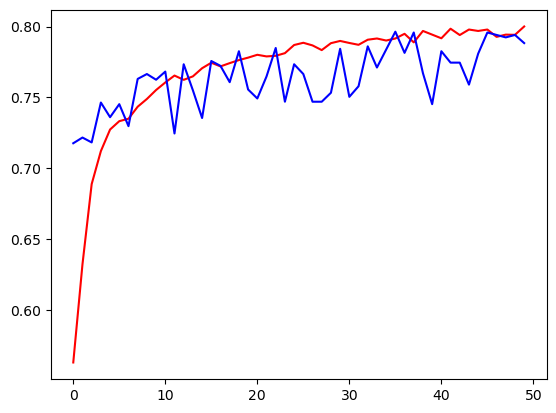

In [95]:
plt.plot(his["accuracy"], c="r")
plt.plot(his["val_accuracy"], c="b")
plt.show()

In [28]:
clf = RandomForestClassifier(n_estimators=400, max_depth=45)
x_tr, x_test, y_tr, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)
print(x_tr.shape, y_tr.shape,x_test.shape,y_test.shape)

clf.fit(x_tr,y_tr)
clf.score(x_test,y_test)

(6954, 12) (6954,) (1739, 12) (1739,)


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [138]:
clf = AdaBoostClassifier(n_estimators=800)
clf.fit(x_tr,y_tr)
clf.score(x_test,y_test)

ValueError: Input X contains NaN.
AdaBoostClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
test = pd.read_csv("test.csv").fillna(0)
test = transform(test.copy())[
    ["CryoSleep", "Cabin", "Age", "VIP", "Earth", "Europa", "Mars", "TRAPPIST-1e", "55 Cancri e", "PSO J318.5-22","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
]
x_test = np.array(data.values)

In [ ]:
sub = pd.read_csv("sample_submission").fillna(0)
sub.Transported = pd.DataFrame((model.predict(x_test) >= 0.5).astype(int)).astype(bool)
pd.DataFrame(sub[["PassengerId","Transported"]]).to_csv("resultNN.csv",index=False)